# Anomaly detection for temperature and pressure measurements

We attempt to use an Autoencoder with convolutional layers to detect anomalies in the temperature measurements. First, however, we consider the effects of changes in the temperature setpoints which introduces level shifts for two points in time. 

### Get dependencies and data

In [6]:
# import dependencies
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [8]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [9]:
# define X vars - we are only concerned with GH pressure and temperature
x_vars = [
    ('pressure', 'DC_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('setpoints', 'DC_GP101_default'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

In [10]:
# filter columns to keep only x_vars
data = data[x_vars].copy()
print(data.columns)

print('\n\n Number of NAs\n')
print(data.isna().sum())

# remove NANs
data = data.dropna(
    how='any', 
    subset=x_vars
)

MultiIndex([(    'pressure',                 'DC_GP101'),
            ('temperatures',         'TA01_GT10X_GM10X'),
            (   'setpoints',         'DC_GP101_default'),
            (   'setpoints', 'TA01_GT10X_GM10X_default')],
           names=['category', 'sensor_ID'])


## Accounting for setpoint changes

No. of unique vals for setpoints:
sensor_ID
DC_GP101_default            2
TA01_GT10X_GM10X_default    6
dtype: int64


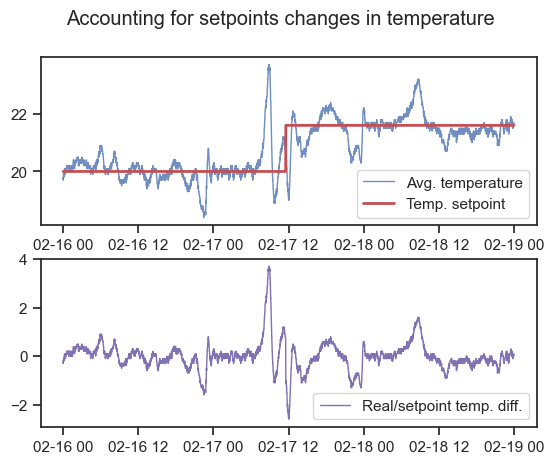

In [11]:
# indoor temp and indoor pressure is dependent on setpoints, 
# hence consider DIFF between setpoint and actual val for
# anomaly detection
print('No. of unique vals for setpoints:')
print(data.setpoints.nunique())

# create new cols w. diff
#data[('pressure', 'DC_GP101_diff')] = 0
data[('pressure', 'DC_GP101_diff')] = data[('pressure', 'DC_GP101')] - data[('setpoints', 'DC_GP101_default')]
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# plot differences f. last day
day = (2, (16, 17, 18))#, 18, 19, 20, 21))
subset = data.loc[day, :].droplevel(level=[0, 1, 2], axis=0).copy()

# set style
sns.set(style='ticks')

# get subplots (upper w. variable setpoint, lower w. accounted for)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints changes in temperature')

# plot avg. temp and setpoints
ax1.plot(
    subset.temperatures.TA01_GT10X_GM10X, 
    linewidth=1.0, 
    alpha=0.8, 
    label='Avg. temperature'
)
ax1.plot(
    subset.setpoints.TA01_GT10X_GM10X_default, 
    linewidth=2.0,
    alpha=1.0, 
    c='r', 
    label='Temp. setpoint'
)
ax2.plot(
    subset.temperatures.TA01_GT10X_GM10X_diff, 
    linewidth=1.0, 
    alpha=1.0, 
    c='m', 
    label='Real/setpoint temp. diff.'
)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.savefig(plot_path + 'setpoint.png')
plt.show()


### Accounting for erroneous setpoint observations

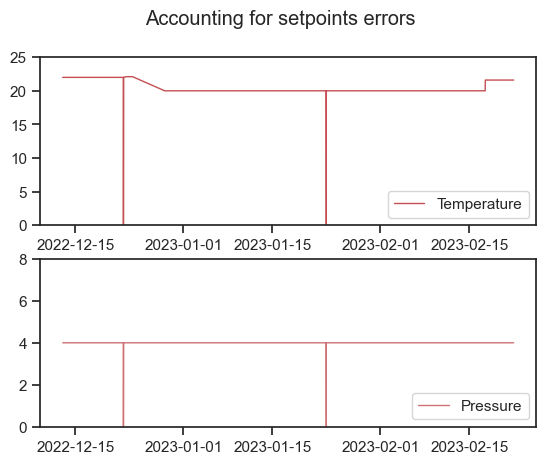

In [12]:
# also instances where setpoints have momentarily gone to zero. 
# display below.
# clearly erroneous?

# show setpoint errors)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints errors')

# plot setpoonts errors
ax1.plot(
    data.setpoints.TA01_GT10X_GM10X_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=1.0, 
    alpha=1.0, 
    c='r', 
    label='Temperature'
)
ax2.plot(
    data.setpoints.DC_GP101_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=1.0, 
    alpha=0.8, 
    c='r', 
    label='Pressure'
)

# set ylims f. visibility
ax1.set_ylim(0, 25)
ax2.set_ylim(0, 8)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.show()

In [13]:
### remove erroneous setpoint rows
data = data[
    (data.setpoints.TA01_GT10X_GM10X_default != 0.0) &
    (data.setpoints.DC_GP101_default != 0.0)
]

print('Minimum vals for setpoints:')
data.setpoints.min()

Minimum vals for setpoints:


sensor_ID
DC_GP101_default             4.0
TA01_GT10X_GM10X_default    20.0
dtype: float64

## Test AE on temperature data

We split data temporally, using data from December and January as training data, while testing on data in February.

In [59]:
def seq_extract(x, n_steps):
    """
    Create sequences f. CNN, incl. channel dim.
    """
    n = len(x)
    
    sequences = np.stack([
        x[i:i+n_steps] for i in range(n - n_steps)
    ])
    
    return sequences[..., np.newaxis]

def data_split(data, var):
    """
    Split and whiten data. Using training mean and s.d. also for test data.
    """
    x_train = data[data.index.get_level_values(0) != 2 ][var].values
    x_test = data[data.index.get_level_values(0) == 2][var].values
    
    # Whiten both sets w. training params
    mean = np.mean(x_train)
    std = np.std(x_train)
    
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # get sequences
    x_train = seq_extract(
        x=x_train,
        n_steps=120
    )

    x_test = seq_extract(
        x=x_test,
        n_steps=120
    )
    
    return x_train, x_test
    

In [16]:
# get data f. temp. diff.
x_train, x_test = data_split(
    data=data,
    var=('temperatures', 'TA01_GT10X_GM10X_diff')
)

### Define model

In [17]:
# define list w. layers
layerList = [
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(
        filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1D(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose(
        filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

temp_model = keras.Sequential(layers=layerList, name='temp_model')
temp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
temp_model.summary()

Model: "temp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            512       
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 60, 32)           7200      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 60, 32)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 120, 64)          14400     
 ranspose)                                              

### Train model

In [162]:
trainHist = model.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

# get reconstructions and plot for test set
x_predicted = temp_model.predict(x_test)


Epoch 1/20
769/769 [==============================] - 32s 42ms/step - loss: 0.0189 - val_loss: 0.0022
Epoch 2/20
769/769 [==============================] - 33s 43ms/step - loss: 0.0142 - val_loss: 0.0030
Epoch 3/20
769/769 [==============================] - 33s 43ms/step - loss: 0.0121 - val_loss: 0.0030
Epoch 4/20
769/769 [==============================] - 32s 42ms/step - loss: 0.0088 - val_loss: 0.0045
Epoch 5/20
769/769 [==============================] - 32s 42ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 6/20
769/769 [==============================] - 32s 41ms/step - loss: 0.0085 - val_loss: 0.0132


### Visualize reconstruction

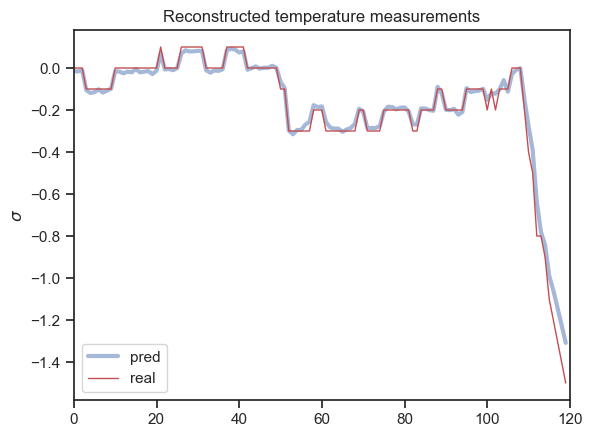

In [180]:
# plot for test set
plt.plot(x_predicted[-1], label='reconstructed', c='b', alpha=0.5, linewidth=3.0)
plt.plot(x_test[-1], label='real', c='r', alpha=1.0, linewidth=1.0)

plt.title('Reconstructed temperature measurements')
plt.ylabel('$\sigma$')
plt.xlim(0, 120)
plt.legend()

#plt.savefig(fname=plot_path + 'reconstructed.png', dpi=500)

In [174]:
# get MAE loss from training the AE
train_mae_loss = np.mean(np.abs(x_pred - x_train), axis=1)
test_mae_loss = np.mean(np.abs(x_pred_test - x_test), axis=1)

# set a threshold, roughly the maximum difference in standard deviations from the mean
#threshold = 1.0
threshold = np.max(train_mae_loss)

# get index and create temp dataset w. flags f. anomalies
idx = np.squeeze(np.array(test_mae_loss) > threshold)
temp = data[data.index.get_level_values(0) == 2].iloc[120:].copy()
temp['flag'] = idx

# groupby individual days and plot number of flagged observations
errs = temp.groupby(by=['month', 'day'])['flag'].sum()

# print "anomaly" dates:
print('By setting the threshold to {:.2f} s.d., we get the following flagged dates:'.format(threshold))
errs[errs > 0]

By setting the threshold to 1.81 s.d., we get the following flagged dates:


Series([], Name: flag, dtype: int64)

## Test AE on pressure data

We split data temporally, using data from December and January as training data, while testing on data in February. Using same architecture as for temperature model, i.e. 128-64-Z-64-128. 

In [19]:
x_train, x_test = data_split(
    data=data,
    var=('pressure', 'DC_GP101')
)

pressure_model = keras.Sequential(layers=layerList, name='pressure_model')
pressure_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
pressure_model.summary()

trainHist = pressure_model.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

x_predTrain = pressure_model.predict(x_train)
x_predicted = pressure_model.predict(x_test)

Model: "pressure_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            512       
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 60, 32)           7200      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 60, 32)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 120, 64)          14400     
 ranspose)                                          

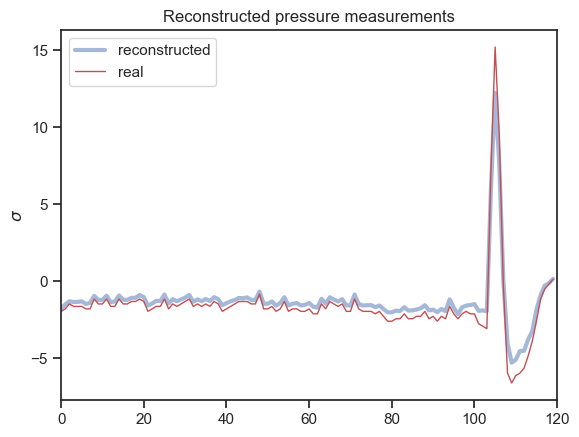

In [70]:
# plot for test set
plt.plot(x_predicted[-1], label='reconstructed', c='b', alpha=0.5, linewidth=3.0)
plt.plot(x_test[-1], label='real', c='r', alpha=1.0, linewidth=1.0)

plt.title('Reconstructed pressure measurements')
plt.ylabel('$\sigma$')
plt.xlim(0, 120)
#plt.ylim(-4, 4)
plt.legend(loc='upper left')
plt.savefig(fname=plot_path + 'press_reconstructed_2.png', dpi=500)

In [71]:
# get MAE loss from training the AE
train_mae_loss = np.mean(np.abs(x_predTrain - x_train), axis=1)
test_mae_loss = np.mean(np.abs(x_predicted - x_test), axis=1)

# set a threshold, roughly the maximum difference in standard deviations from the mean
#threshold = 1.0
threshold = np.max(train_mae_loss)

# get index and create temp dataset w. flags f. anomalies
idx = np.squeeze(np.array(test_mae_loss) > threshold)
temp = data[data.index.get_level_values(0) == 2].iloc[120:].copy()
temp['flag'] = idx

# groupby individual days and plot number of flagged observations
errs = temp.groupby(by=['month', 'day'])['flag'].sum()

# print "anomaly" dates:
print('By setting the threshold to {:.2f} s.d., we get the following flagged dates:'.format(threshold))
errs[errs > 0]

By setting the threshold to 1.03 s.d., we get the following flagged dates:


Series([], Name: flag, dtype: int64)